In [60]:
import pandas as pd
import numpy as np
import re
from experiment_utils import get_latest_files
from post_processing import series_name, violin_plots_per_iteration, violin_plots, error_estimation, merge_estimates_true, compute_val_metrics, under_over_analysis, under_over_by_method, val_metrics_per_iteration, boxplots, boxplots_per_iteration, add_weights, exponential_weights_paper

Constants

In [61]:
pretty_methods = {'Holdout': 'Holdout', 
                'Repeated_Holdout': 'Repeated Holdout', 
                'Growing_Window': 'Growing Window', 
                'Rolling_Window': 'Rolling Window',
                'Block_CV': 'Block CV', 
                'AdaptedhvBlockCV': 'Adapted hv-Block CV', 
                'MarkovCV': 'Markov CV',
                'Block_CV_with_weights_paper': 'Weighted Block CV var.1', 
                'Block_CV_with_weights': 'Weighted Block CV var.2',
                'Growing_Window_with_weights': 'Weighted Growing Window', 
                'Rolling_Window_with_weights': 'Weighted Rolling Window'}

Functions

In [62]:
def clean_filename(filepath):
    filename = filepath.split('/')[-1]
    
    filename = filename.rsplit('.', 1)[0]
    
    # Check if the filename ends with a date in the format DDMMYYYY or similar
    # and remove the date if it exists
    filename = re.sub(r'_\d{8}$', '', filename)
    
    return filename

def clean_method(method_str):
    parts = method_str.split('.')
    if len(parts) > 3:
        method_name = parts[3].split()[0]
    else:
        method_name = parts[-1].split()[0]
    return method_name

def prettify(df, pretty_methods: dict = pretty_methods):
    copy = df.copy()
    copy['method'] = copy['method'].map(pretty_methods)
    return copy

## Upload Data

### Real Data

Be carefull with "get_latest_files" when lstm results are ready!

In [63]:
[get_latest_files('results/saude', 'table_A'), 
get_latest_files('results/transportes', 'table_A'), 
get_latest_files('results/eco_financas', 'table_A'), 
get_latest_files('results/eng_ciencias', 'table_A'), 
get_latest_files('results/energia', 'table_A'), 
get_latest_files('results/ambiente', 'table_A'), 
get_latest_files('results/meteorologia', 'table_A')]

['results/saude\\table_A_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_A_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv']

In [64]:
# Validation Results
saude = pd.read_csv('results/saude\\table_A_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes = pd.read_csv('results/transportes\\table_A_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas = pd.read_csv('results/eco_financas\\table_A_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias = pd.read_csv('results/eng_ciencias\\table_A_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia = pd.read_csv('results/energia\\table_A_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente = pd.read_csv('results/ambiente\\table_A_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia = pd.read_csv('results/meteorologia\\table_A_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

val_dict = {'saude': saude,
 'transportes': transportes,
 'eco_financas':eco_financas,
 'eng_ciencias': eng_ciencias,
 'energia': energia,
 'ambiente': ambiente,
 'meteorologia': meteorologia
 }

In [65]:
real_data_val = pd.concat(val_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_val

,Field,filename,column_index,method,iteration,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,Tree,1122.564394,20.017677,33.504692
1,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,ARMA,1097.670935,20.360957,33.131117
2,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,Tree,197.821429,8.396104,14.064901
3,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,ARMA,4652.950871,64.066829,68.212542
4,saude,datasets/processed_data/covid19_17052024.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,1,Tree,182.480132,8.099338,13.508521
...,...,...,...,...,...,...,...,...,...
2725,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,7,ARMA,47.402579,5.636406,6.884953
2726,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,Tree,63.853138,5.510571,7.990816
2727,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,8,ARMA,52.510323,5.949948,7.246401
2728,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,<timecave.validation_methods.markov.MarkovCV o...,9,Tree,74.284770,6.082853,8.618861


In [66]:
[get_latest_files('results/saude', 'table_B'), 
get_latest_files('results/transportes', 'table_B'), 
get_latest_files('results/eco_financas', 'table_B'), 
get_latest_files('results/eng_ciencias', 'table_B'), 
get_latest_files('results/energia', 'table_B'), 
get_latest_files('results/ambiente', 'table_B'), 
get_latest_files('results/meteorologia', 'table_B')]

['results/saude\\table_B_saude_2024_06_06__15_04_07.csv',
 'results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv',
 'results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv',
 'results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv',
 'results/energia\\table_B_energia_2024_06_06__17_51_10.csv',
 'results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv',
 'results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv']

In [67]:
# Test Results
saude_test = pd.read_csv('results/saude\\table_B_saude_2024_06_06__15_04_07.csv', dtype={'column_index': 'string'})
transportes_test = pd.read_csv('results/transportes\\table_B_transportes_2024_06_06__10_53_40.csv', dtype={'column_index': 'string'})
eco_financas_test = pd.read_csv('results/eco_financas\\table_B_eco_financas_2024_06_06__17_36_19.csv', dtype={'column_index': 'string'})
eng_ciencias_test = pd.read_csv('results/eng_ciencias\\table_B_eng_ciencias_2024_06_06__20_15_36.csv', dtype={'column_index': 'string'})
energia_test = pd.read_csv('results/energia\\table_B_energia_2024_06_06__17_51_10.csv', dtype={'column_index': 'string'})
ambiente_test = pd.read_csv('results/ambiente\\table_B_ambiente_2024_06_07__10_15_12.csv', dtype={'column_index': 'string'})
meteorologia_test = pd.read_csv('results/meteorologia\\table_B_meteorologia_2024_06_07__15_27_00.csv', dtype={'column_index': 'string'})

test_dict = {'saude': saude_test,
 'transportes': transportes_test,
 'eco_financas':eco_financas_test,
 'eng_ciencias': eng_ciencias_test,
 'energia': energia_test,
 'ambiente': ambiente_test,
 'meteorologia': meteorologia_test
 }

In [68]:
real_data_test = pd.concat(test_dict).reset_index(0).rename(columns={'level_0': 'Field'})
real_data_test

,Field,filename,column_index,model,mse,mae,rmse
0,saude,datasets/processed_data/covid19_17052024.csv,0,Tree,17.316252,2.493517,4.161280
1,saude,datasets/processed_data/covid19_17052024.csv,0,ARMA,35.113134,5.037637,5.925634
2,saude,datasets/processed_data/covid19_17052024.csv,1,Tree,5.463435,1.555446,2.337399
3,saude,datasets/processed_data/covid19_17052024.csv,1,ARMA,14.434002,3.375995,3.799211
4,saude,datasets/processed_data/covid19_17052024.csv,2,Tree,8.104641,1.812699,2.846865
...,...,...,...,...,...,...,...
65,meteorologia,datasets/processed_data/jena_climate_data.csv,12,ARMA,23783.710487,4.231992,154.219683
66,meteorologia,datasets/processed_data/jena_climate_data.csv,13,Tree,6025.325689,40.736198,77.622971
67,meteorologia,datasets/processed_data/jena_climate_data.csv,13,ARMA,7167.891640,68.984216,84.663402
68,meteorologia,datasets/processed_data/MLTempDataset_13052024...,0,Tree,10.731559,1.387957,3.275906


### Synthetic Data

In [117]:
[get_latest_files('results/s1', 'table_A'), 
get_latest_files('results/s2', 'table_A'), 
get_latest_files('results/s3', 'table_A')]

['results/s1\\table_A_s1_414_1000_LSTM_2024_06_19__12_57_51.csv',
 'results/s2\\table_A_s2_645_1000_LSTM_2024_06_21__12_32_08.csv',
 'results/s3\\table_A_s3_2024_06_07__17_30_48.csv']

In [118]:
# Validation Results
s1_1 = pd.read_csv('results/s1\\table_A_s1_0_200_2024_06_07__11_28_28.csv', dtype={'column_index': 'string'})
s1_2 = pd.read_csv('results/s1\\table_A_s1_200_1001_2024_06_07__12_00_51.csv', dtype={'column_index': 'string'})
s2_1 = pd.read_csv('results/s2\\table_A_s2_0_200_2024_06_07__11_38_43.csv', dtype={'column_index': 'string'})
s2_2 = pd.read_csv('results/s2\\table_A_s2_200_1001_2024_06_07__12_11_58.csv', dtype={'column_index': 'string'})
s3 = pd.read_csv('results/s3\\table_A_s3_2024_06_07__17_30_48.csv', dtype={'column_index': 'string'})

val_dict = {
's1': s1_1,
's1_2': s1_2,
's2': s2_1,
's2_2': s2_2,
's3':s3
 }

In [119]:
syn_data_val = pd.concat(val_dict).reset_index(0).rename(columns={'level_0': 'Field'})
syn_data_val['Field'] = syn_data_val['Field'].map({'s1': 's1', 's2': 's2','s1_2': 's1', 's2_2': 's2', 's3': 's3'})
syn_data_val

,Field,filename,column_index,method,iteration,model,mse,mae,rmse
0,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,Tree,2.290200e+00,1.212833,1.513341
1,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Holdout objec...,0,ARMA,1.747274e+00,1.008874,1.321845
2,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,Tree,2.557555e+00,1.351258,1.599236
3,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,0,ARMA,1.652459e+00,1.030527,1.285480
4,s1,datasets/synthetic_data/s1.csv,0,<timecave.validation_methods.OOS.Repeated_Hold...,1,Tree,3.059749e+00,1.464176,1.749214
...,...,...,...,...,...,...,...,...,...
77995,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,7,ARMA,2.617459e+07,4236.730735,5116.110406
77996,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,8,Tree,1.958592e+06,1370.483420,1399.497139
77997,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,8,ARMA,5.514686e+06,1990.997347,2348.336855
77998,s3,datasets/synthetic_data/s3.csv,999,<timecave.validation_methods.markov.MarkovCV o...,9,Tree,8.393755e+05,806.445944,916.174364


In [120]:
[get_latest_files('results/s1', 'table_B'), 
get_latest_files('results/s2', 'table_B'), 
get_latest_files('results/s3', 'table_B')]

['results/s1\\table_B_s1_414_1000_LSTM_2024_06_19__12_57_51.csv',
 'results/s2\\table_B_s2_645_1000_LSTM_2024_06_21__12_32_08.csv',
 'results/s3\\table_B_s3_2024_06_07__17_30_48.csv']

In [121]:
# Test Results
s1_1_test = pd.read_csv('results/s1\\table_B_s1_0_200_2024_06_07__11_28_28.csv', dtype={'column_index': 'string'})
s1_2_test = pd.read_csv('results/s1\\table_B_s1_200_1001_2024_06_07__12_00_51.csv', dtype={'column_index': 'string'})
s2_1_test = pd.read_csv('results/s2\\table_B_s2_0_200_2024_06_07__11_38_43.csv', dtype={'column_index': 'string'})
s2_2_test = pd.read_csv('results/s2\\table_B_s2_200_1001_2024_06_07__12_11_58.csv', dtype={'column_index': 'string'})
s3_test = pd.read_csv('results/s3\\table_B_s3_2024_06_07__17_30_48.csv', dtype={'column_index': 'string'})

test_dict = {
's1': s1_1_test,
's1_2': s1_2_test,
's2': s2_1_test,
's2_2': s2_2_test,
's3':s3_test
 }

In [122]:
syn_data_test = pd.concat(test_dict).reset_index(0).rename(columns={'level_0': 'Field'})
syn_data_test['Field'] = syn_data_test['Field'].map({'s1': 's1', 's2': 's2','s1_2': 's1', 's2_2': 's2', 's3': 's3'})
syn_data_test

,Field,filename,column_index,model,mse,mae,rmse
0,s1,datasets/synthetic_data/s1.csv,0,Tree,2.239900e+00,1.216184,1.496630
1,s1,datasets/synthetic_data/s1.csv,0,ARMA,2.726234e+00,1.342448,1.651131
2,s1,datasets/synthetic_data/s1.csv,1,Tree,6.658242e+00,2.083506,2.580357
3,s1,datasets/synthetic_data/s1.csv,1,ARMA,1.337243e+01,2.930200,3.656833
4,s1,datasets/synthetic_data/s1.csv,2,Tree,1.130832e+01,2.703739,3.362784
...,...,...,...,...,...,...,...
1995,s3,datasets/synthetic_data/s3.csv,997,ARMA,9.453888e+05,780.109492,972.311062
1996,s3,datasets/synthetic_data/s3.csv,998,Tree,1.586311e+06,852.319457,1259.488341
1997,s3,datasets/synthetic_data/s3.csv,998,ARMA,5.073560e+06,1714.979950,2252.456450
1998,s3,datasets/synthetic_data/s3.csv,999,Tree,2.658804e+06,1431.174835,1630.583863


# Analysing Results

In [97]:
data_val, data_test = syn_data_val, syn_data_test

### Preprocessing results

In [98]:
data_val['filename'] = data_val['filename'].apply(clean_filename)
data_val['method'] = data_val['method'].apply(clean_method)
data_val = series_name(data_val)
data_val

,series,Field,method,iteration,model,mse,mae,rmse
0,s1_0,s1,Holdout,0,Tree,2.290200e+00,1.212833,1.513341
1,s1_0,s1,Holdout,0,ARMA,1.747274e+00,1.008874,1.321845
2,s1_0,s1,Repeated_Holdout,0,Tree,2.557555e+00,1.351258,1.599236
3,s1_0,s1,Repeated_Holdout,0,ARMA,1.652459e+00,1.030527,1.285480
4,s1_0,s1,Repeated_Holdout,1,Tree,3.059749e+00,1.464176,1.749214
...,...,...,...,...,...,...,...,...
77995,s3_999,s3,MarkovCV,7,ARMA,2.617459e+07,4236.730735,5116.110406
77996,s3_999,s3,MarkovCV,8,Tree,1.958592e+06,1370.483420,1399.497139
77997,s3_999,s3,MarkovCV,8,ARMA,5.514686e+06,1990.997347,2348.336855
77998,s3_999,s3,MarkovCV,9,Tree,8.393755e+05,806.445944,916.174364


In [99]:
data_test['filename'] = data_test['filename'].apply(clean_filename)
data_test = series_name(data_test)
data_test

,series,Field,model,mse,mae,rmse
0,s1_0,s1,Tree,2.239900e+00,1.216184,1.496630
1,s1_0,s1,ARMA,2.726234e+00,1.342448,1.651131
2,s1_1,s1,Tree,6.658242e+00,2.083506,2.580357
3,s1_1,s1,ARMA,1.337243e+01,2.930200,3.656833
4,s1_2,s1,Tree,1.130832e+01,2.703739,3.362784
...,...,...,...,...,...,...
1995,s3_997,s3,ARMA,9.453888e+05,780.109492,972.311062
1996,s3_998,s3,Tree,1.586311e+06,852.319457,1259.488341
1997,s3_998,s3,ARMA,5.073560e+06,1714.979950,2252.456450
1998,s3_999,s3,Tree,2.658804e+06,1431.174835,1630.583863


In [100]:
data_val = add_weights(data_val, preq_methods = ['Growing_Window', 'Rolling_Window'], CV_methods = ['Block_CV'])
data_val

,series,Field,method,iteration,model,mse,mae,rmse,weights
0,s1_0,s1,Holdout,0,Tree,2.290200e+00,1.212833,1.513341,1.000000
1,s1_0,s1,Holdout,0,ARMA,1.747274e+00,1.008874,1.321845,1.000000
2,s1_0,s1,Repeated_Holdout,0,Tree,2.557555e+00,1.351258,1.599236,1.000000
3,s1_0,s1,Repeated_Holdout,0,ARMA,1.652459e+00,1.030527,1.285480,1.000000
4,s1_0,s1,Repeated_Holdout,1,Tree,3.059749e+00,1.464176,1.749214,1.000000
...,...,...,...,...,...,...,...,...,...
341995,s3_999,s3,Rolling_Window_with_weights,3,ARMA,1.874451e+06,1175.785980,1369.105830,0.266667
341996,s3_999,s3,Rolling_Window_with_weights,1,Tree,9.156483e+06,2966.614172,3025.968099,0.066667
341997,s3_999,s3,Rolling_Window_with_weights,1,ARMA,9.396107e+06,3016.919101,3065.307028,0.066667
341998,s3_999,s3,Rolling_Window_with_weights,2,Tree,1.862282e+07,4286.522536,4315.416610,0.133333


### Results

#### Tables

In [101]:
est_data_val = error_estimation(data_val)
est_data_val

,series,method,model,mse,mae
0,s1_0,AdaptedhvBlockCV,ARMA,1.834027e+00,1.103111
1,s1_0,AdaptedhvBlockCV,Tree,2.113990e+00,1.152961
2,s1_0,Block_CV,ARMA,1.845601e+00,1.111344
3,s1_0,Block_CV,Tree,2.181882e+00,1.168376
4,s1_0,Block_CV_with_weights,ARMA,1.739911e+00,1.066320
...,...,...,...,...,...
65995,s3_999,Repeated_Holdout,Tree,1.842517e+06,1146.103578
65996,s3_999,Rolling_Window,ARMA,1.178093e+07,2978.538386
65997,s3_999,Rolling_Window,Tree,6.260765e+06,2042.071692
65998,s3_999,Rolling_Window_with_weights,ARMA,8.508922e+06,2437.768034


In [102]:
estimates = merge_estimates_true(est_data_val, data_test)
all_metrics = compute_val_metrics(estimates, 'mse')
all_metrics

,Mean,Median,1st_Quartile,3rd_Quartile,Minimum,Maximum,Standard_deviation,method,model,metric
0,3.099312e+06,0.344300,-0.461058,5.756243e+00,-7.480982e+07,1.646217e+08,1.336110e+07,AdaptedhvBlockCV,ARMA,PAE
1,4.665307e+06,1.003667,0.393310,2.857232e+06,9.275004e-04,1.646217e+08,1.289805e+07,AdaptedhvBlockCV,ARMA,APAE
2,2.190287e+00,0.150813,-0.154045,7.361479e-01,-9.608139e-01,2.250042e+02,1.030016e+01,AdaptedhvBlockCV,ARMA,RPAE
3,2.398210e+00,0.334388,0.152351,8.052978e-01,3.784024e-04,2.250042e+02,1.025375e+01,AdaptedhvBlockCV,ARMA,RAPAE
4,2.469532e-01,0.140238,-0.166900,5.380903e-01,-1.849166e+00,1.982379e+00,6.869141e-01,AdaptedhvBlockCV,ARMA,sMPAE
...,...,...,...,...,...,...,...,...,...,...
105,1.519977e+06,1.057020,-0.053588,1.016296e+06,-5.222639e+07,5.006472e+07,5.863114e+06,Rolling_Window_with_weights,Tree,PAE
106,2.439481e+06,1.567404,0.599177,2.089443e+06,3.387878e-04,5.222639e+07,5.543949e+06,Rolling_Window_with_weights,Tree,APAE
107,1.694234e+00,0.364228,-0.016578,1.217938e+00,-9.546770e-01,1.108472e+02,4.815180e+00,Rolling_Window_with_weights,Tree,RPAE
108,1.829176e+00,0.437497,0.179612,1.217938e+00,7.730644e-05,1.108472e+02,4.765554e+00,Rolling_Window_with_weights,Tree,RAPAE


In [103]:
under_over_analysis(estimates, 'mse')[0]

,Mean,Median,1st_Quartile,3rd_Quartile,Minimum,Maximum,Standard_deviation,N,%,method,model,metric
0,-2.049732e+06,-0.762685,-12.907727,-0.317868,-7.480982e+07,-1.107332e-03,5.995400e+06,1146,38.20,AdaptedhvBlockCV,ARMA,PAE
1,2.049732e+06,0.762685,0.317868,12.907727,1.107332e-03,7.480982e+07,5.995400e+06,1146,38.20,AdaptedhvBlockCV,ARMA,APAE
2,-2.721512e-01,-0.215249,-0.368873,-0.112801,-9.608139e-01,-5.765912e-04,2.142963e-01,1146,38.20,AdaptedhvBlockCV,ARMA,RPAE
3,2.721512e-01,0.215249,0.112801,0.368873,5.765912e-04,9.608139e-01,2.142963e-01,1146,38.20,AdaptedhvBlockCV,ARMA,RAPAE
4,-1.671544e+06,-1.037419,-302503.962962,-0.447049,-5.502532e+07,-3.775843e-04,5.159757e+06,1247,41.57,AdaptedhvBlockCV,Tree,PAE
...,...,...,...,...,...,...,...,...,...,...,...,...
83,3.046347e-01,0.243434,0.133001,0.415526,1.362623e-03,9.656426e-01,2.299841e-01,1167,38.90,Rolling_Window_with_weights,ARMA,RAPAE
84,-1.757013e+06,-0.846444,-2.553049,-0.324667,-5.222639e+07,-3.387878e-04,5.536006e+06,785,26.17,Rolling_Window_with_weights,Tree,PAE
85,1.757013e+06,0.846444,0.324667,2.553049,3.387878e-04,5.222639e+07,5.536006e+06,785,26.17,Rolling_Window_with_weights,Tree,APAE
86,-2.578505e-01,-0.197957,-0.348165,-0.087800,-9.546770e-01,-7.730644e-05,2.238557e-01,785,26.17,Rolling_Window_with_weights,Tree,RPAE


In [104]:
under_over_by_method(estimates, 'mse')

(            Mean    Median  1st_Quartile  3rd_Quartile       Minimum  \
 0  -1.852657e+06 -0.934020 -2.147436e+05 -3.734922e-01 -7.480982e+07   
 1   1.852657e+06  0.934020  3.734922e-01  2.147436e+05  3.775843e-04   
 2  -2.811988e-01 -0.221903 -3.747393e-01 -1.108330e-01 -9.724599e-01   
 3   2.811988e-01  0.221903  1.108330e-01  3.747393e-01  1.335911e-04   
 4  -1.836392e+06 -0.929435 -2.134386e+05 -3.610453e-01 -7.476607e+07   
 5   1.836392e+06  0.929435  3.610453e-01  2.134386e+05  2.031972e-03   
 6  -2.811545e-01 -0.220936 -3.838996e-01 -1.090498e-01 -9.775165e-01   
 7   2.811545e-01  0.220936  1.090498e-01  3.838996e-01  1.938306e-04   
 8  -1.974617e+06 -1.119125 -5.511986e+05 -4.177931e-01 -8.886962e+07   
 9   1.974617e+06  1.119125  4.177931e-01  5.511986e+05  1.128231e-03   
 10 -3.093002e-01 -0.254283 -4.149066e-01 -1.256809e-01 -9.781130e-01   
 11  3.093002e-01  0.254283  1.256809e-01  4.149066e-01  3.300035e-04   
 12 -1.967749e+06 -1.094722 -5.034179e+05 -4.055250

In [105]:
iteration_data = pd.merge(left=data_val, right=data_test, on=["model", "series"], suffixes=["_estimate", "_true"]);

In [106]:
metrics = val_metrics_per_iteration(iteration_data, 'mse', methods_list=['Block_CV_with_weights', 'Block_CV'])
metrics

method model iteration           PAE            \
                                                   mean    median   
0                Block_CV  ARMA         0  7.558927e+06  0.246179   
1                Block_CV  ARMA         1  4.599019e+06  0.221863   
2                Block_CV  ARMA         2  2.681028e+06  0.212322   
3                Block_CV  ARMA         3  7.505962e+05  0.181228   
4                Block_CV  ARMA         4 -2.244084e+05 -0.008633   
5                Block_CV  Tree         0 -3.782879e+04 -0.006100   
6                Block_CV  Tree         1 -4.851699e+05 -0.028515   
7                Block_CV  Tree         2 -5.164922e+05 -0.046765   
8                Block_CV  Tree         3 -5.271438e+05 -0.037864   
9                Block_CV  Tree         4  2.091289e+04  0.026019   
10  Block_CV_with_weights  ARMA         1  4.599019e+06  0.221863   
11  Block_CV_with_weights  ARMA         2  2.681028e+06  0.212322   
12  Block_CV_with_weights  ARMA         3  7.505962e+05  0.181228   
13  Block_CV_with_weights  ARMA         4 -2.244084e+05 -0.008633   
14  Block_CV_with_weights  Tree         1 -4.851699e+05 -0.028515   
15  Block_CV_with_weights  Tree         2 -5.164922e+05 -0.046765   
16  Block_CV_with_weights  Tree         3 -5.271438e+05 -0.037864   
17  Block_CV_with_weights  Tree         4  2.091289e+04  0.026019   

                                                      APAE            ...  \
             min           max           std          mean    median  ...   
0  -5.164173e+07  3.616318e+08  2.784994e+07  9.088020e+06  1.314702  ...   
1  -8.095622e+07  2.298191e+08  1.957280e+07  6.371118e+06  1.363122  ...   
2  -8.768382e+07  2.180661e+08  1.428867e+07  4.590711e+06  1.267768  ...   
3  -1.065528e+08  1.010580e+08  8.441098e+06  2.958151e+06  1.376645  ...   
4  -8.131365e+07  4.961126e+07  6.282545e+06  2.320736e+06  1.270562  ...   
5  -5.519498e+07  4.505050e+07  4.539069e+06  1.431132e+06  1.566574  ...   
6  -5.599146e+07  2.065925e+07  3.898901e+06  1.146086e+06  1.494574  ...   
7  -5.442679e+07  2.486022e+07  3.919875e+06  1.119444e+06  1.528339  ...   
8  -5.391803e+07  2.145487e+07  3.877716e+06  1.121683e+06  1.593942  ...   
9  -5.516713e+07  6.065594e+07  4.920264e+06  1.485913e+06  1.511199  ...   
10 -8.095622e+07  2.298191e+08  1.957280e+07  6.371118e+06  1.363122  ...   
11 -8.768382e+07  2.180661e+08  1.428867e+07  4.590711e+06  1.267768  ...   
12 -1.065528e+08  1.010580e+08  8.441098e+06  2.958151e+06  1.376645  ...   
13 -8.131365e+07  4.961126e+07  6.282545e+06  2.320736e+06  1.270562  ...   
14 -5.599146e+07  2.065925e+07  3.898901e+06  1.146086e+06  1.494574  ...   
15 -5.442679e+07  2.486022e+07  3.919875e+06  1.119444e+06  1.528339  ...   
16 -5.391803e+07  2.145487e+07  3.877716e+06  1.121683e+06  1.593942  ...   
17 -5.516713e+07  6.065594e+07  4.920264e+06  1.485913e+06  1.511199  ...   

        RPAE                                                RAPAE            \
        mean    median       min         max        std      mean    median   
0   4.310338  0.108809 -0.985519  602.740788  22.410403  4.606833  0.419977   
1   2.946255  0.105761 -0.994099  381.862848  15.481551  3.246911  0.414271   
2   1.916787  0.092052 -0.986987  194.652161   9.786958  2.221800  0.406791   
3   1.087549  0.072584 -0.977696   99.439140   5.469737  1.419604  0.409018   
4   0.598254 -0.004837 -0.979725  132.231245   3.892606  0.998429  0.393143   
5   0.579520 -0.001975 -0.986860   77.608785   3.074610  0.930769  0.359054   
6   0.274546 -0.007287 -0.989641   31.008481   1.466838  0.643662  0.354350   
7   0.239617 -0.010952 -0.984819   16.745799   1.289565  0.607105  0.349582   
8   0.251084 -0.010570 -0.989735   25.903156   1.306070  0.618673  0.351400   
9   0.564693  0.007836 -0.990172   88.309378   3.441644  0.914937  0.355168   
10  2.946255  0.105761 -0.994099  381.862848  15.481551  3.246911  0.414271   
11  1.916787  0.092052 -0.986987  194.652161   9.786958  2.221800  0.4

#### Graphs

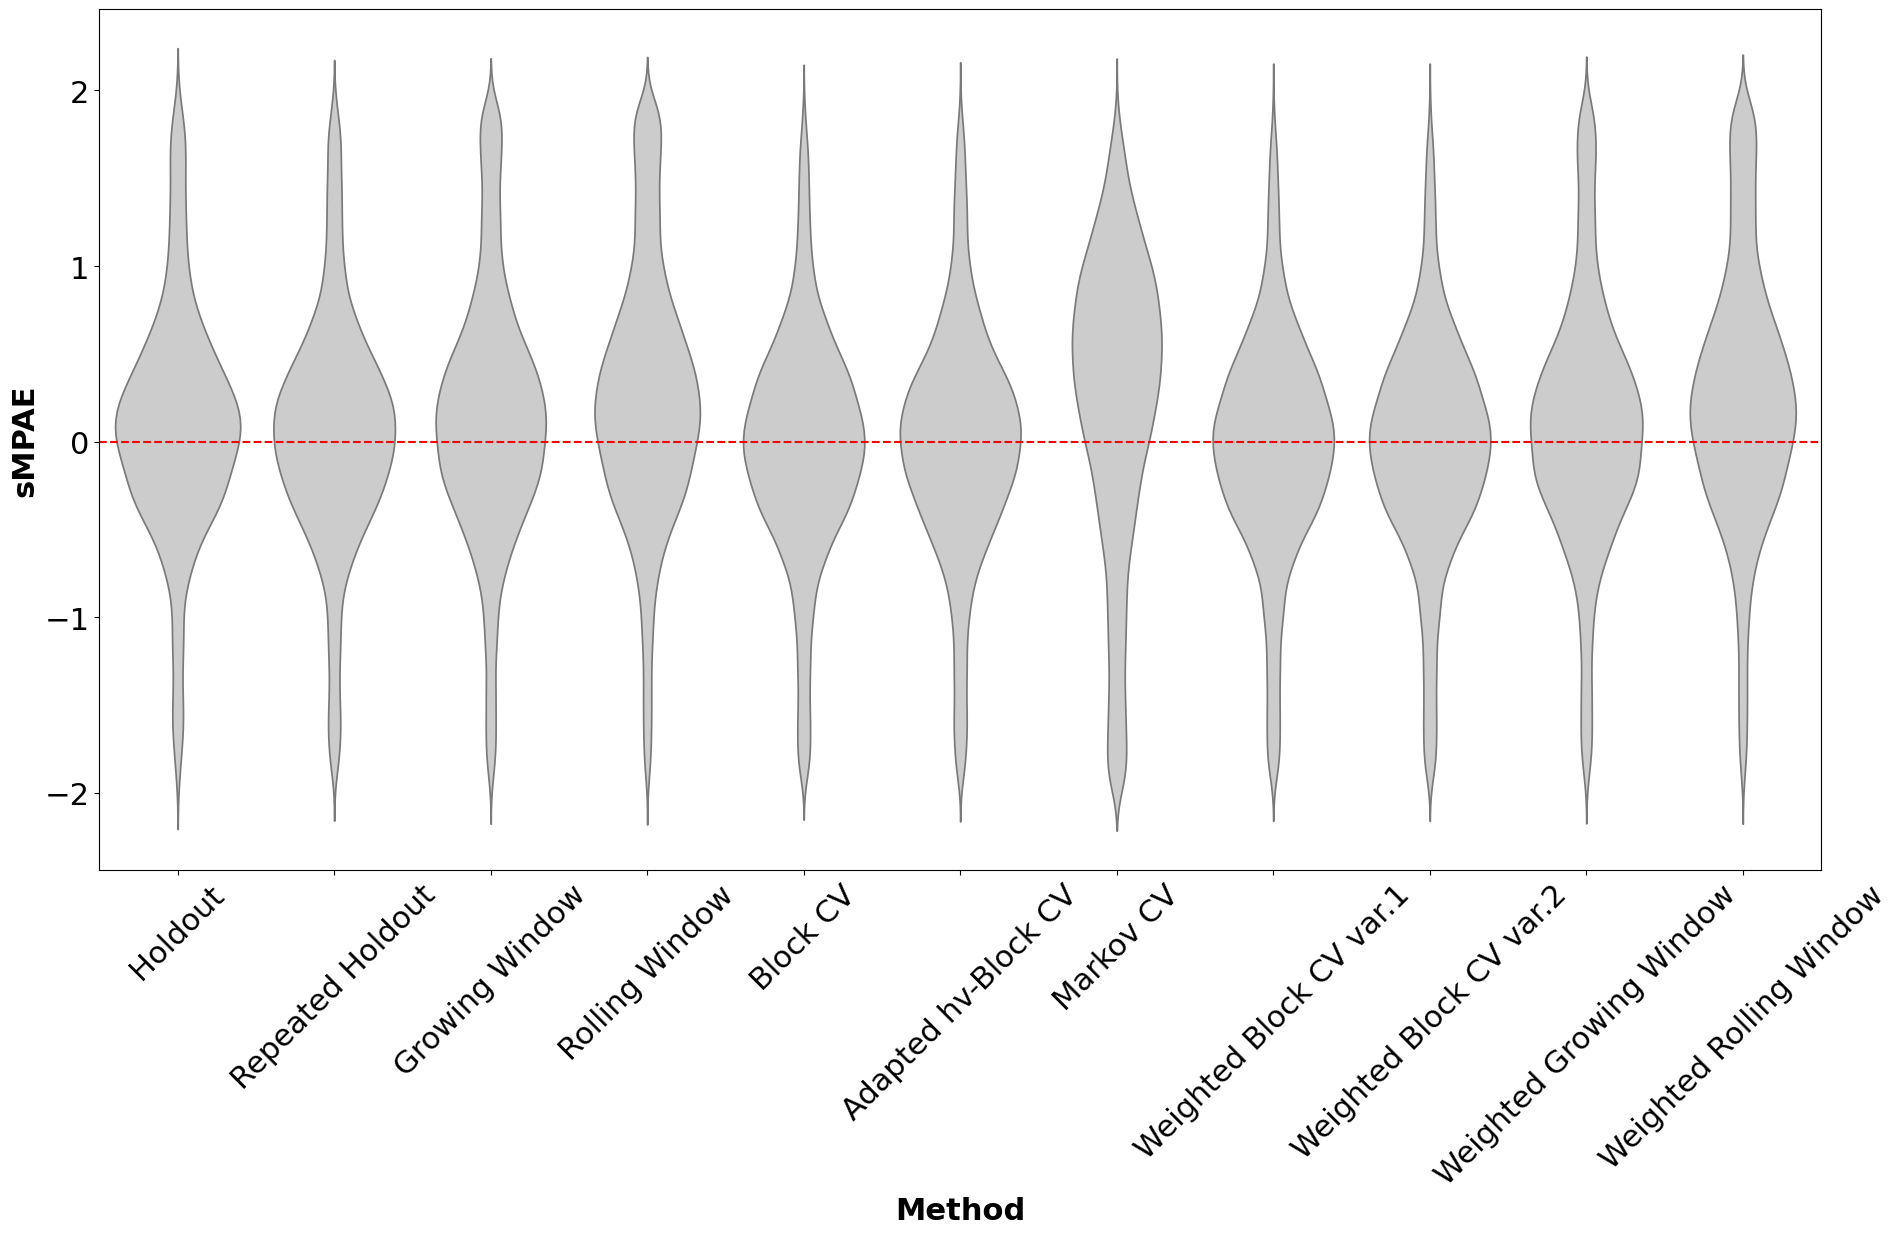

In [107]:
methods = ['Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
violin_plots(prettify(iteration_data), "mse", "Tree", ["sMPAE"], 10, 20)

In [108]:
methods = ['Block_CV', 'Block_CV_with_weights_paper']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
it

,series,Field_estimate,method,iteration,model,mse_estimate,mae_estimate,rmse_estimate,weights,Field_true,mse_true,mae_true,rmse_true
38,s1_0,s1,Block_CV,0,Tree,2.086818e+00,1.190836,1.444582,1.0000,s1,2.239900e+00,1.216184,1.496630
39,s1_0,s1,Block_CV,0,ARMA,2.473442e+00,1.293631,1.572718,1.0000,s1,2.726234e+00,1.342448,1.651131
40,s1_0,s1,Block_CV,1,Tree,1.238881e+00,0.873387,1.113050,1.0000,s1,2.239900e+00,1.216184,1.496630
41,s1_0,s1,Block_CV,1,ARMA,1.507818e+00,1.057623,1.227932,1.0000,s1,2.726234e+00,1.342448,1.651131
42,s1_0,s1,Block_CV,2,Tree,2.137004e+00,1.210873,1.461849,1.0000,s1,2.239900e+00,1.216184,1.496630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257995,s3_999,s3,Block_CV_with_weights_paper,2,ARMA,2.001330e+07,4324.777655,4473.622230,0.0625,s3,8.132679e+06,2414.592717,2851.785298
257996,s3_999,s3,Block_CV_with_weights_paper,3,Tree,1.895381e+06,1311.448719,1376.728322,0.1250,s3,2.658804e+06,1431.174835,1630.583863
257997,s3_999,s3,Block_CV_with_weights_paper,3,ARMA,1.563977e+06,1000.745615,1250.590646,0.1250,s3,8.132679e+06,2414.592717,2851.785298
257998,s3_999,s3,Block_CV_with_weights_paper,4,Tree,1.468755e+06,1077.225847,1211.921877,0.2500,s3,2.658804e+06,1431.174835,1630.583863


c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:348: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


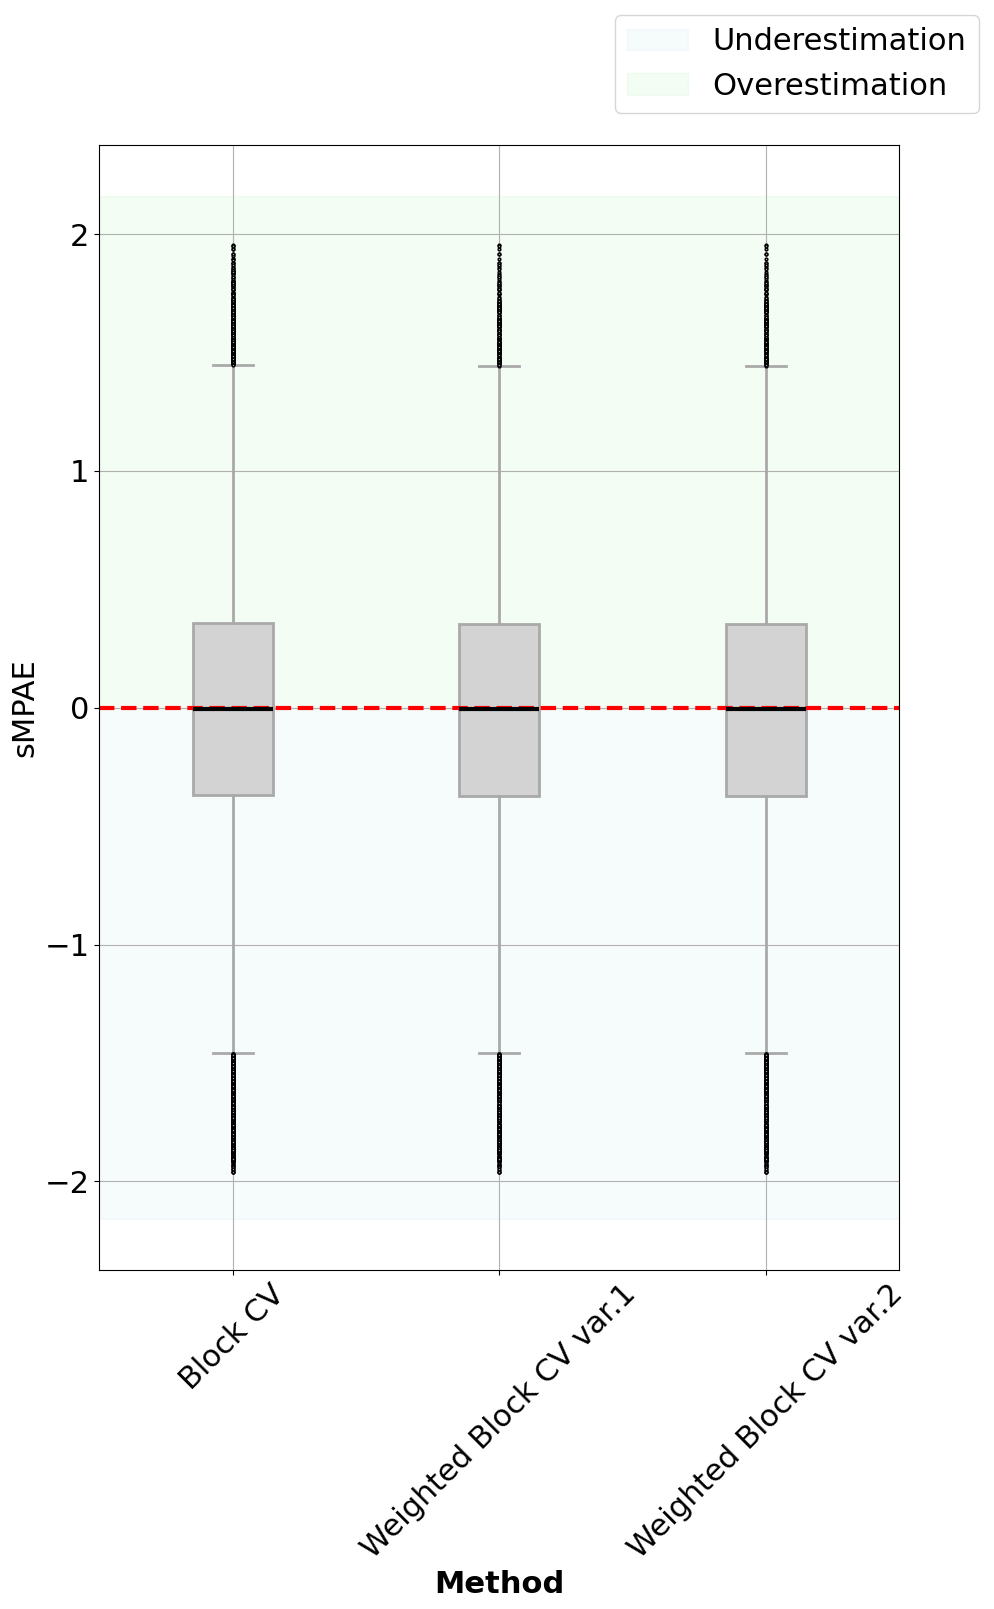

In [109]:
methods = ['Block_CV', 'Block_CV_with_weights_paper', 'Block_CV_with_weights']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(prettify(it), "mse", "Tree", ["sMPAE"], 15, 10, shows_outliers=True)

In [110]:
iteration_data.method.unique()
iteration_data.loc[iteration_data["method"].isin(methods)].copy()

,series,Field_estimate,method,iteration,model,mse_estimate,mae_estimate,rmse_estimate,weights,Field_true,mse_true,mae_true,rmse_true
38,s1_0,s1,Block_CV,0,Tree,2.086818e+00,1.190836,1.444582,1.000000,s1,2.239900e+00,1.216184,1.496630
39,s1_0,s1,Block_CV,0,ARMA,2.473442e+00,1.293631,1.572718,1.000000,s1,2.726234e+00,1.342448,1.651131
40,s1_0,s1,Block_CV,1,Tree,1.238881e+00,0.873387,1.113050,1.000000,s1,2.239900e+00,1.216184,1.496630
41,s1_0,s1,Block_CV,1,ARMA,1.507818e+00,1.057623,1.227932,1.000000,s1,2.726234e+00,1.342448,1.651131
42,s1_0,s1,Block_CV,2,Tree,2.137004e+00,1.210873,1.461849,1.000000,s1,2.239900e+00,1.216184,1.496630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281995,s3_999,s3,Block_CV_with_weights,2,ARMA,2.001330e+07,4324.777655,4473.622230,0.064516,s3,8.132679e+06,2414.592717,2851.785298
281996,s3_999,s3,Block_CV_with_weights,3,Tree,1.895381e+06,1311.448719,1376.728322,0.129032,s3,2.658804e+06,1431.174835,1630.583863
281997,s3_999,s3,Block_CV_with_weights,3,ARMA,1.563977e+06,1000.745615,1250.590646,0.129032,s3,8.132679e+06,2414.592717,2851.785298
281998,s3_999,s3,Block_CV_with_weights,4,Tree,1.468755e+06,1077.225847,1211.921877,0.258065,s3,2.658804e+06,1431.174835,1630.583863


c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:348: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


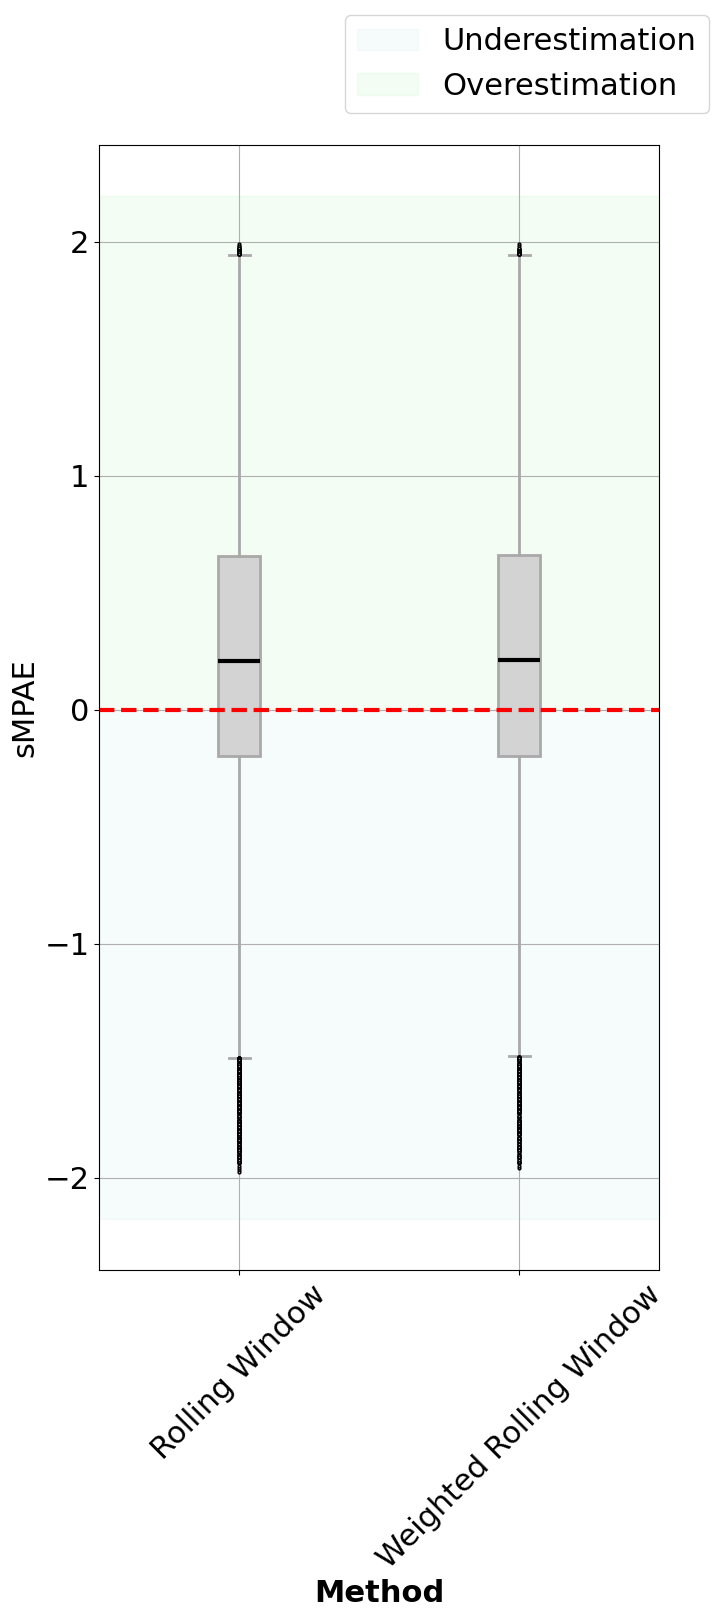

In [111]:
methods = ['Rolling_Window','Rolling_Window_with_weights']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(prettify(it), "mse", "Tree", ["sMPAE"], 15, 7, shows_outliers=True)

c:\Users\User\Desktop\Project_repos\tsvalidation\tsvalidation\experiments\post_processing.py:348: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = boxplot[0].get_figure() if isinstance(boxplot, pd.Series) else boxplot[0, 0].get_figure()


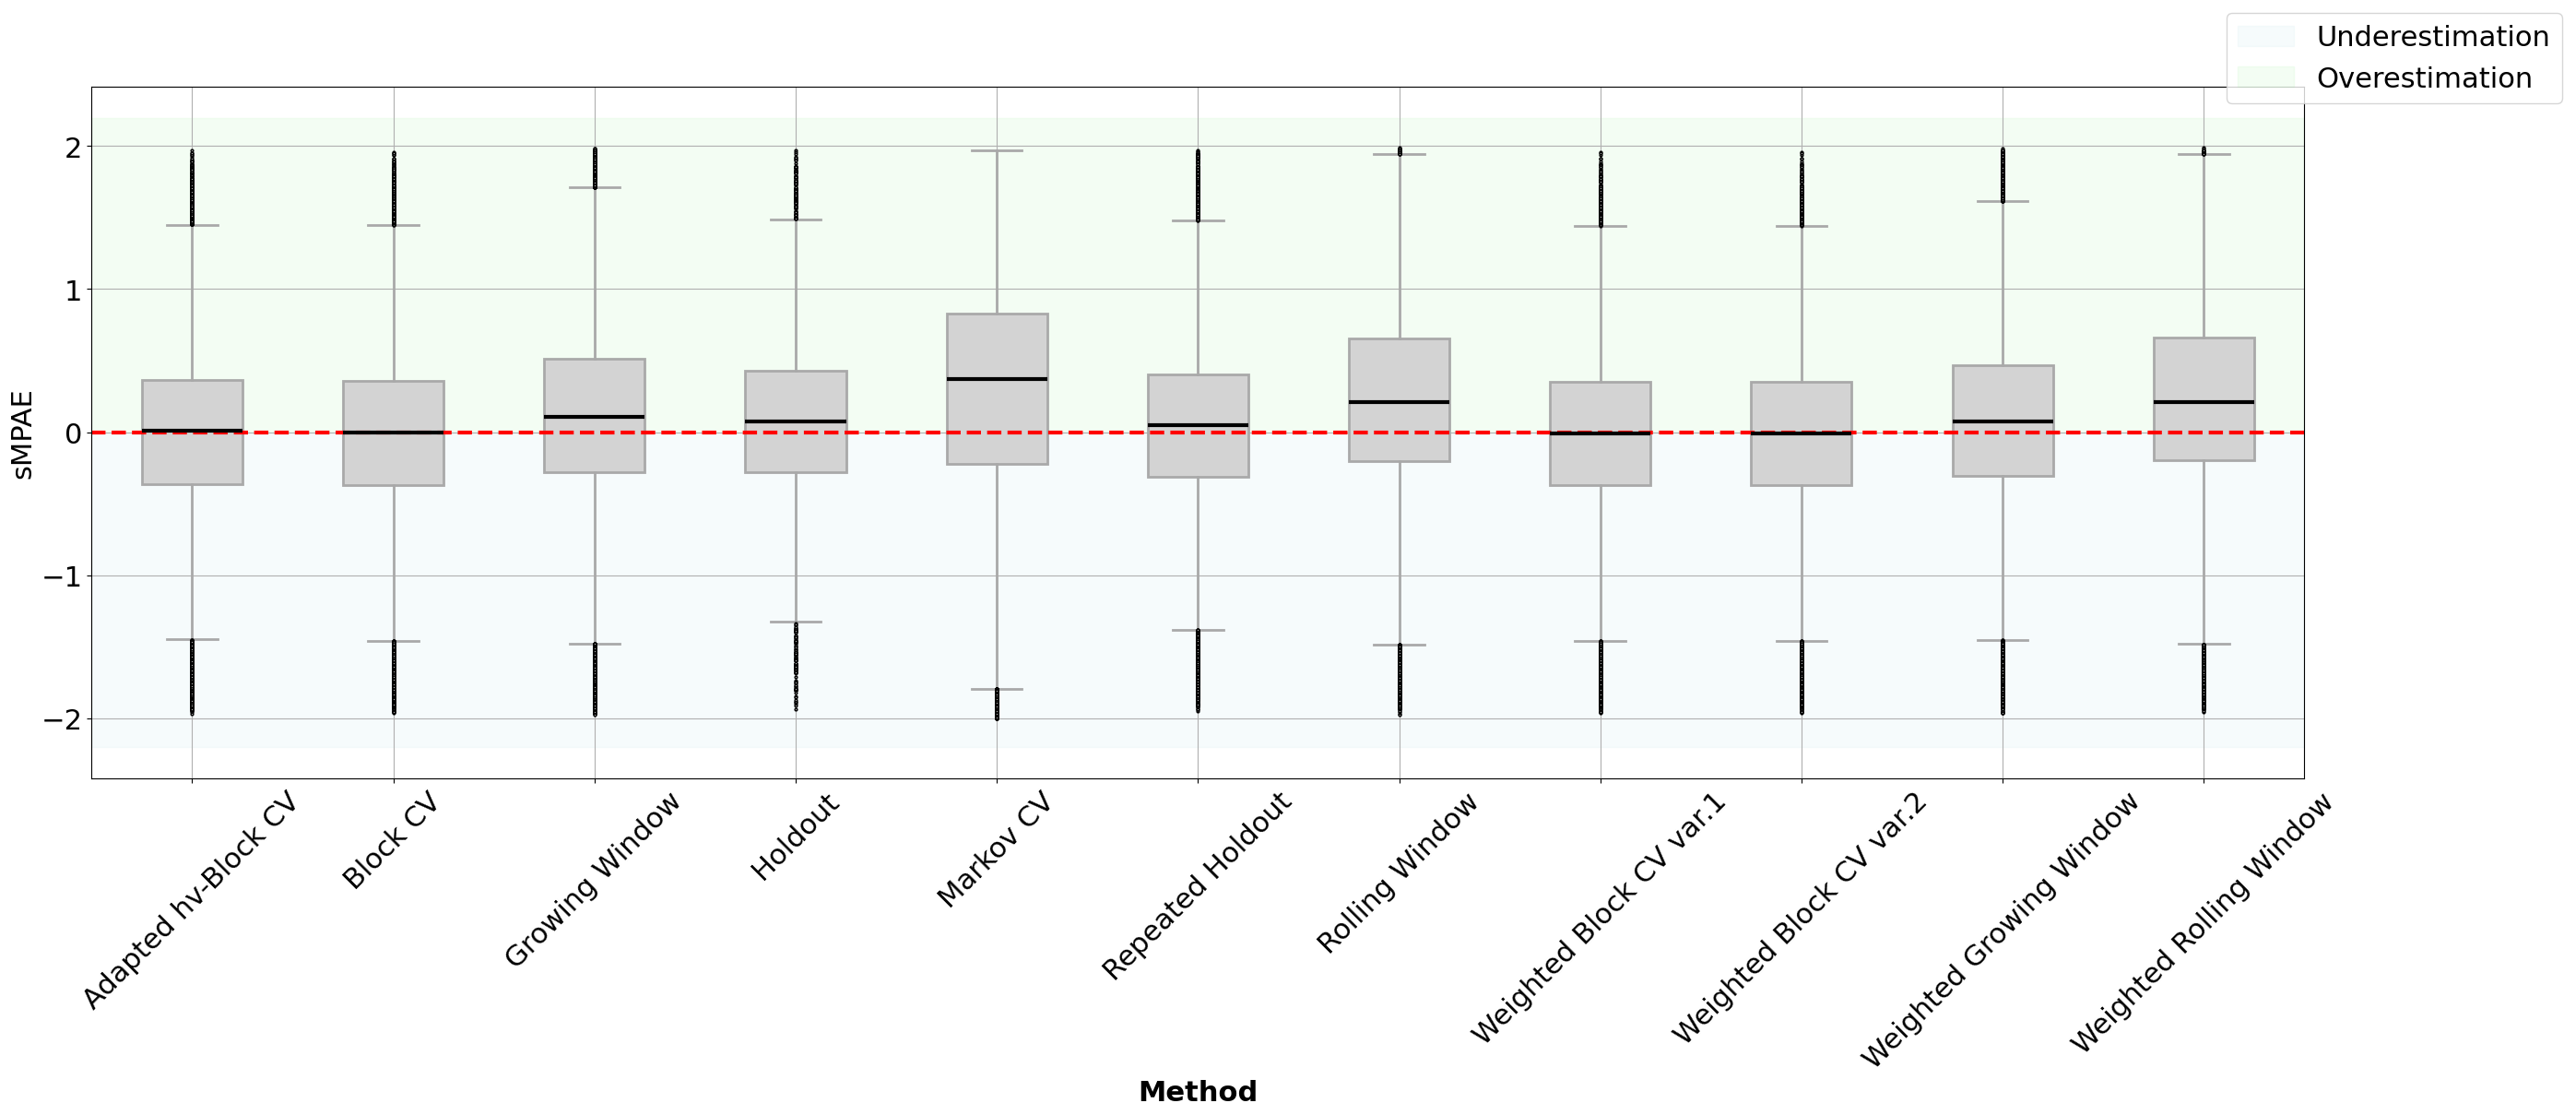

In [124]:
methods = ['Holdout', 'Repeated Holdout']
it = iteration_data.loc[iteration_data["method"].isin(methods)].copy()
boxplots(prettify(iteration_data), "mse", "Tree", ["sMPAE"], 10, 30, shows_outliers=True)

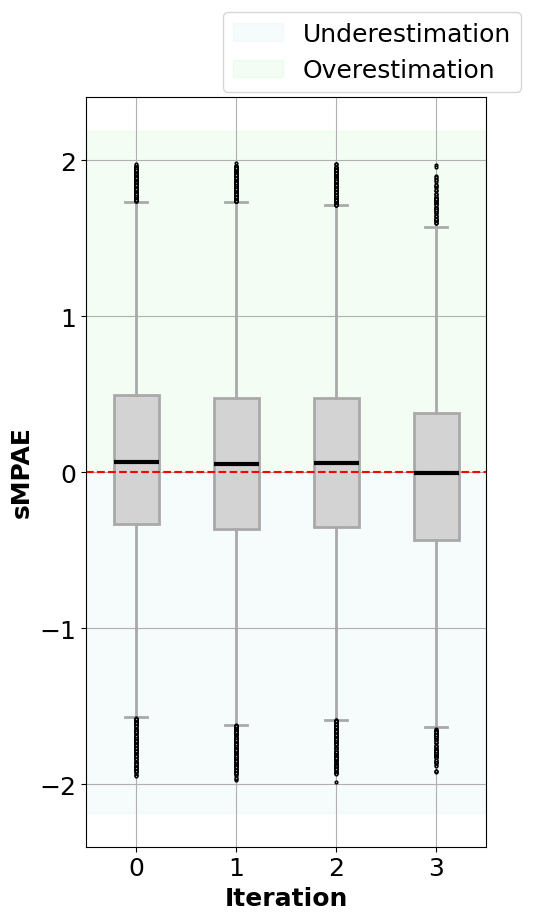

In [113]:
boxplots_per_iteration(prettify(iteration_data), "mse", "ARMA", pretty_methods["Growing_Window"], ["sMPAE"], 10, 5);

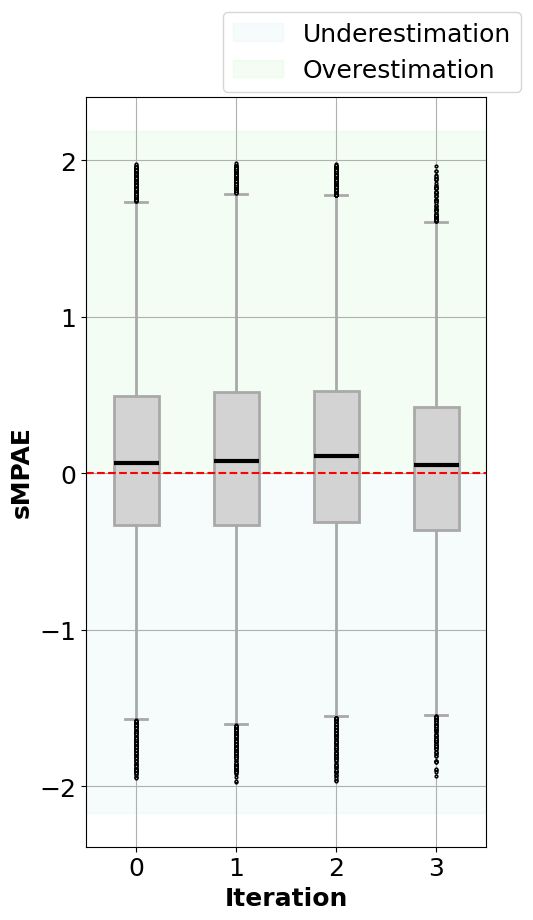

In [114]:
boxplots_per_iteration(prettify(iteration_data), "mse", "ARMA", pretty_methods["Rolling_Window"], ["sMPAE"], 10, 5);

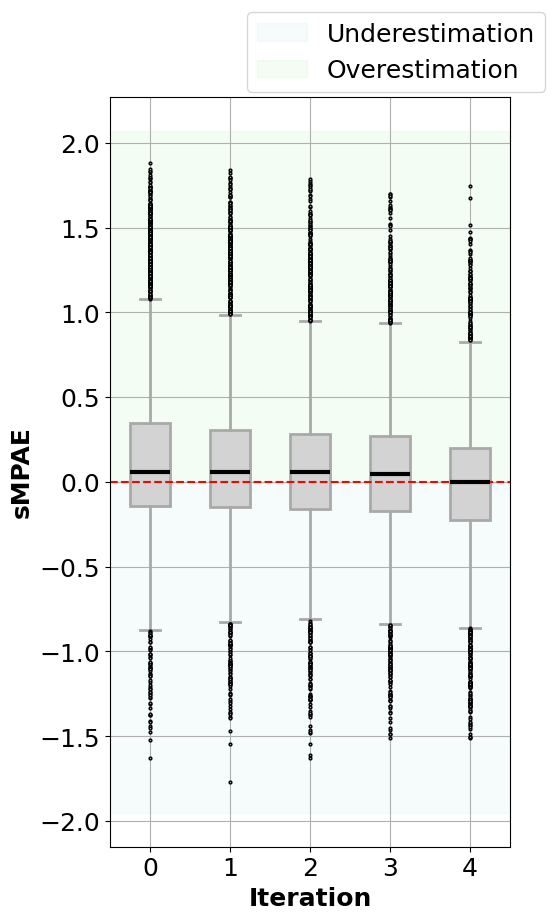

In [115]:
boxplots_per_iteration(prettify(iteration_data), "mae", "ARMA", pretty_methods["Block_CV"], ["sMPAE"], 10, 5);

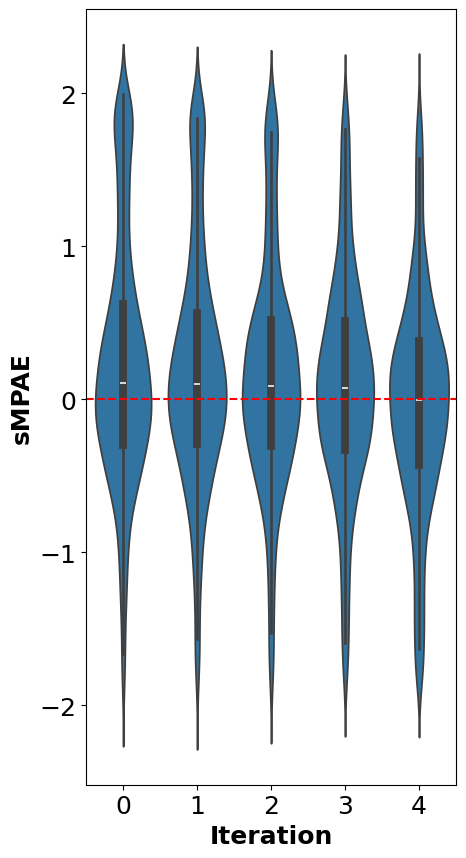

In [116]:
violin_plots_per_iteration(prettify(iteration_data), "mse", "ARMA", pretty_methods["Block_CV"], ["sMPAE"], 10, 5);